In [13]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Setup

In [3]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 1)
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

Cuda installed! Running on GPU 1 GeForce RTX 2080 Ti!


In [7]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi2D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi2D(recon, X)
                v, T = awi2D.v_all[0], awi2D.T_arr

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].imshow(T.detach().cpu().numpy())
                axs[1, 0].set_title("T-2D")

                axs[1, 1].imshow(v.detach().cpu().numpy())
                axs[1, 1].set_title("v-2D")

                axs[1, 2].plot((T.flatten() - v.flatten()).detach().cpu().numpy())
                axs[1, 2].set_ylim(None, 1.1)
                axs[1, 2].set_title("T2D - v2D")

                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss2d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [8]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23071780800819397, 'train_awi1d_loss': 22.6019287109375, 'train_kl_loss': 0.0}
 argidx T, v:  1512 752


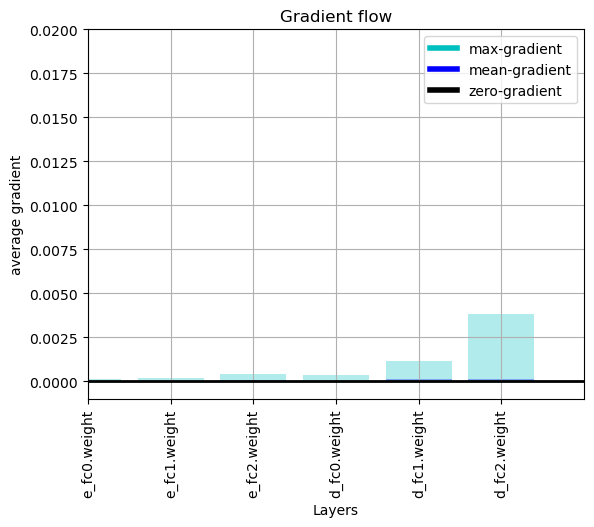

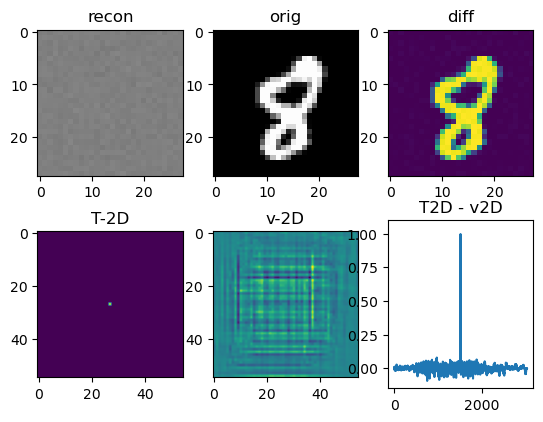

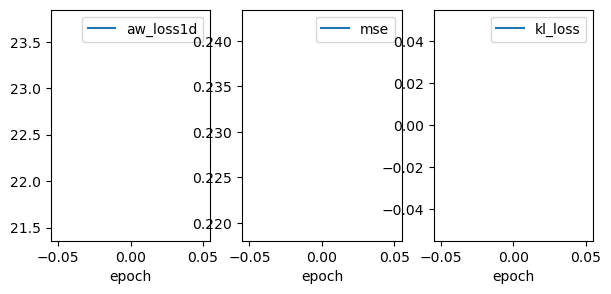

 20% (20 of 100) |####                   | Elapsed Time: 0:02:06 ETA:   0:08:28


 {'epoch': 20, 'train_mse': 0.15787389874458313, 'train_awi1d_loss': 19.600656509399414, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


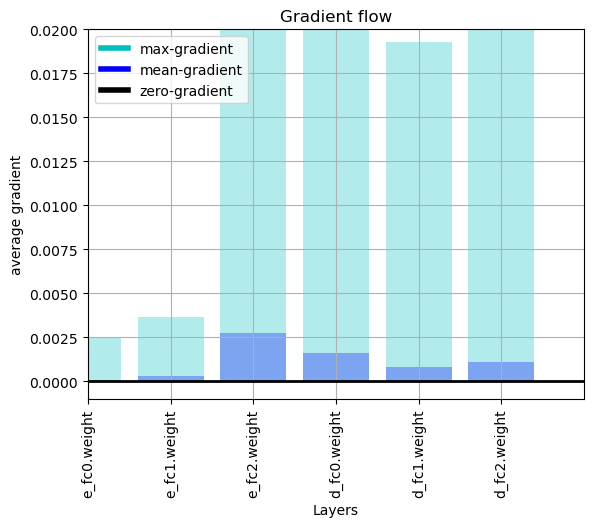

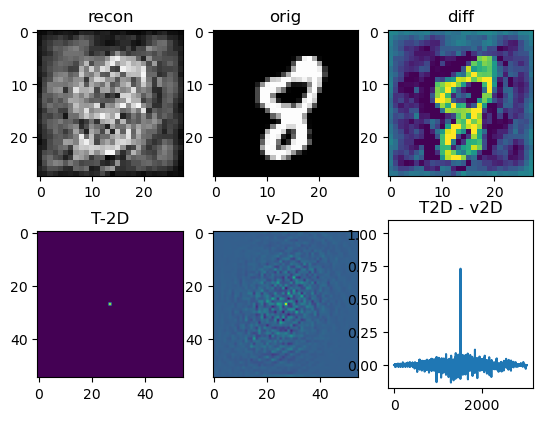

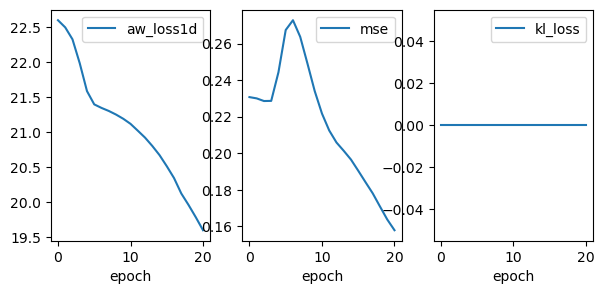

 40% (40 of 100) |#########              | Elapsed Time: 0:04:14 ETA:   0:06:14


 {'epoch': 40, 'train_mse': 0.08358866721391678, 'train_awi1d_loss': 14.29195785522461, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


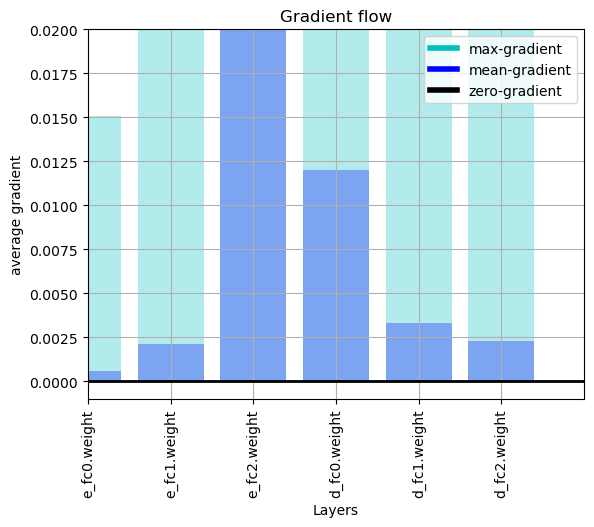

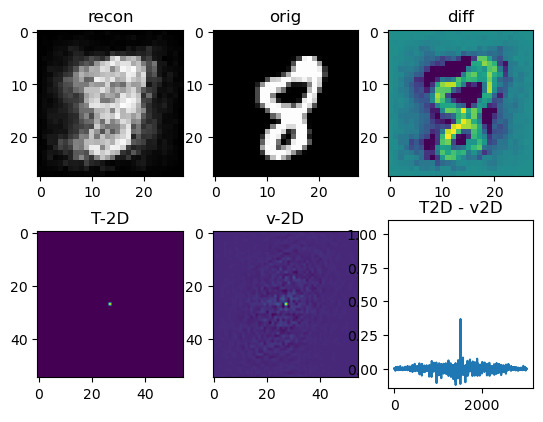

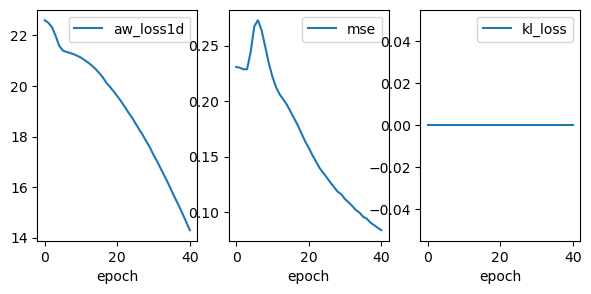

 60% (60 of 100) |#############          | Elapsed Time: 0:06:21 ETA:   0:04:11


 {'epoch': 60, 'train_mse': 0.04650676250457764, 'train_awi1d_loss': 8.94591236114502, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


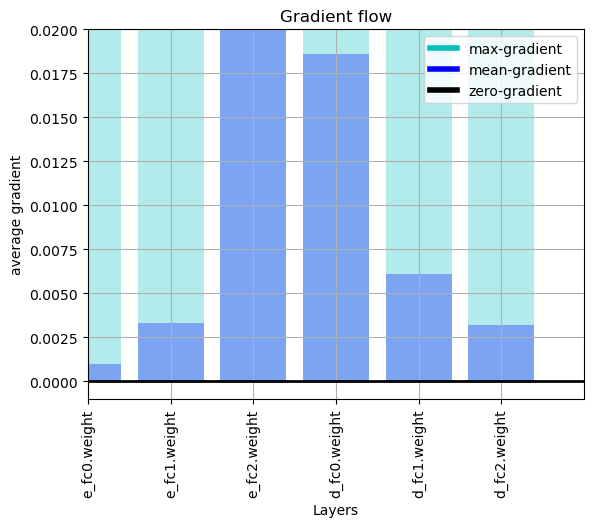

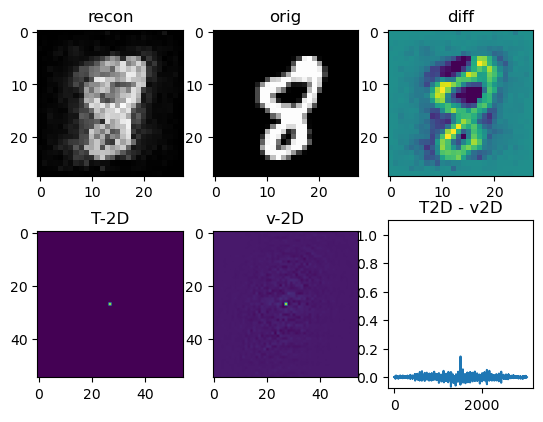

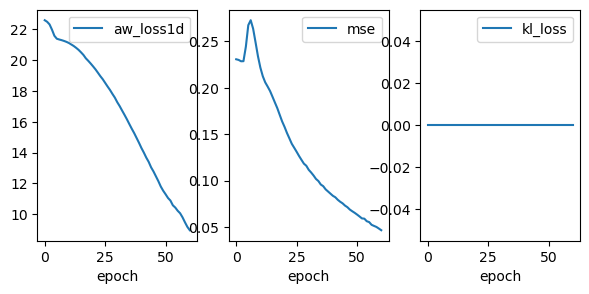

 80% (80 of 100) |##################     | Elapsed Time: 0:08:29 ETA:   0:02:07


 {'epoch': 80, 'train_mse': 0.021453294903039932, 'train_awi1d_loss': 5.998552322387695, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


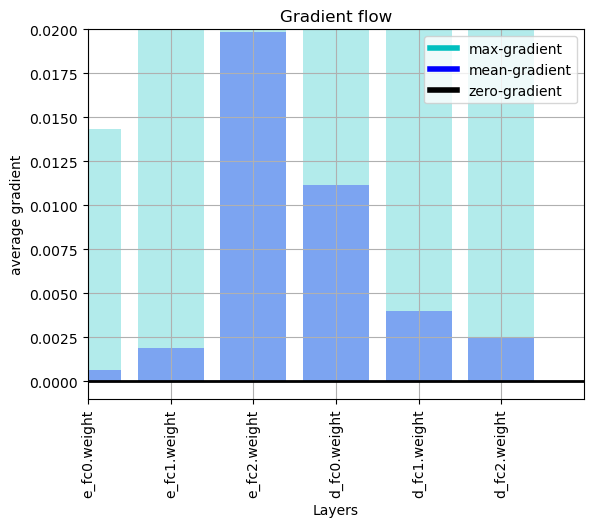

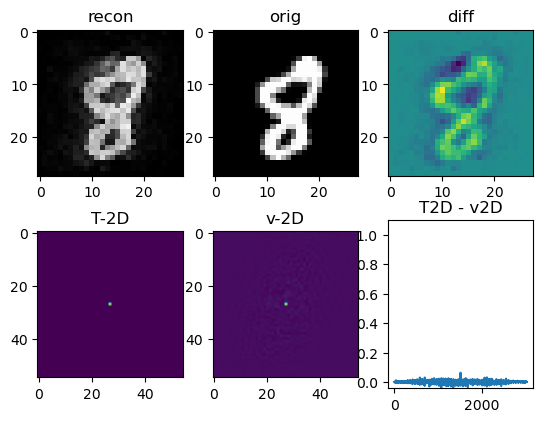

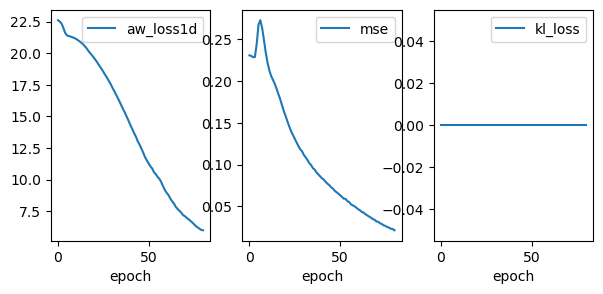

 99% (99 of 100) |###################### | Elapsed Time: 0:10:32 ETA:   0:00:06


 {'epoch': 99, 'train_mse': 0.01178684737533331, 'train_awi1d_loss': 5.023536682128906, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


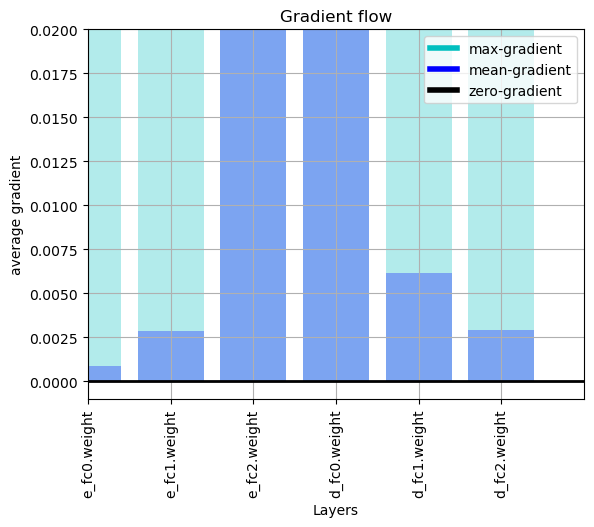

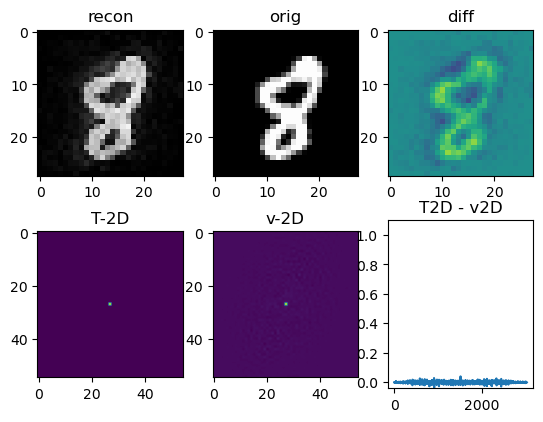

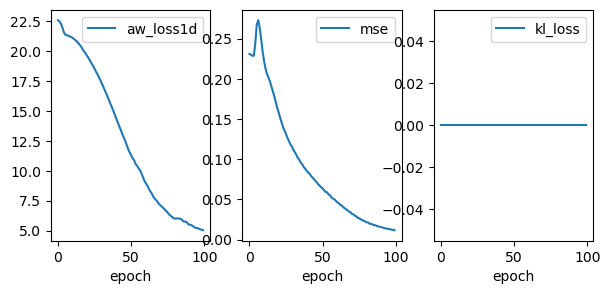

100% (100 of 100) |######################| Elapsed Time: 0:10:32 Time:  0:10:32


In [9]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Visualise Loss Landscape of Autoencoder

Train Subset len:  16
Angle between x_dir and y_dir: 90.01 °


100% (625 of 625) |######################| Elapsed Time: 0:16:12 Time:  0:16:12


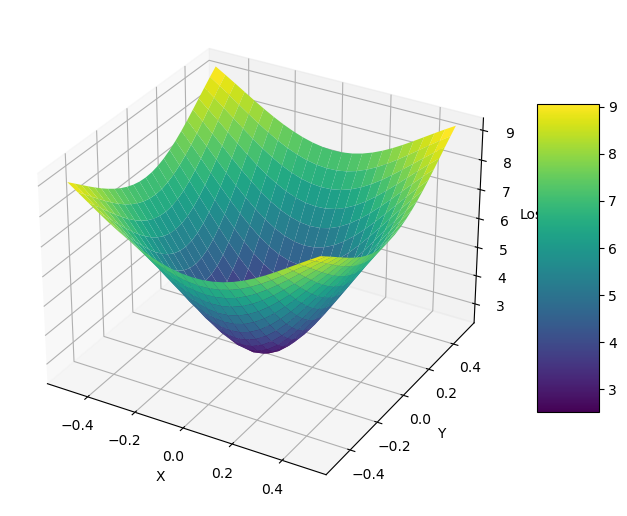

In [10]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi2D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.23141971230506897, 'train_awi1d_loss': 22.625621795654297, 'train_kl_loss': 517.9473876953125}
 argidx T, v:  1512 752


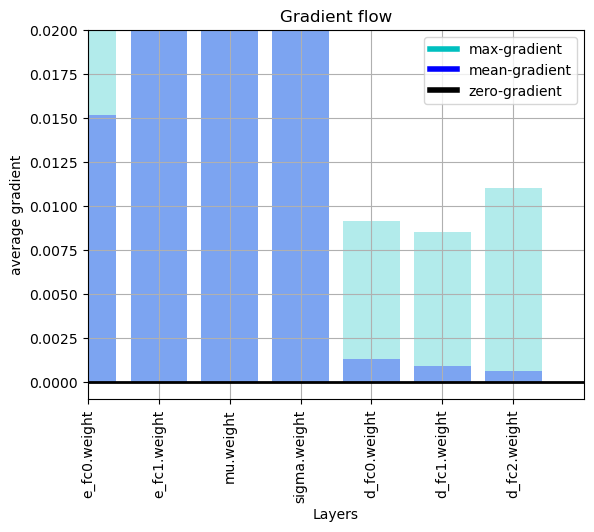

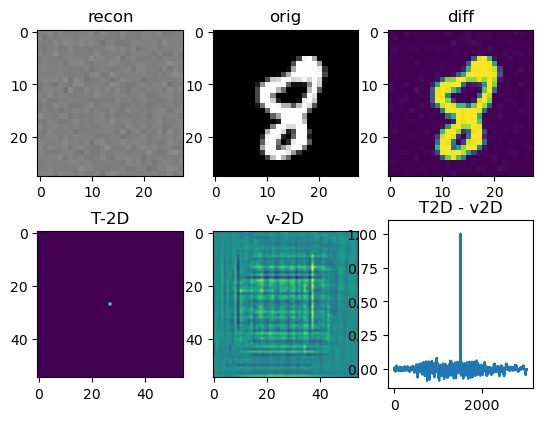

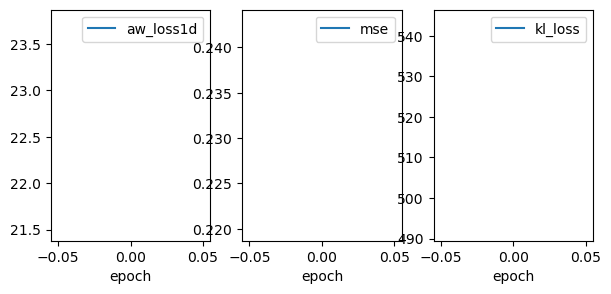

 20% (20 of 100) |####                   | Elapsed Time: 0:02:08 ETA:   0:08:42


 {'epoch': 20, 'train_mse': 0.2105076014995575, 'train_awi1d_loss': 21.214982986450195, 'train_kl_loss': 512.0384521484375}
 argidx T, v:  1512 1512


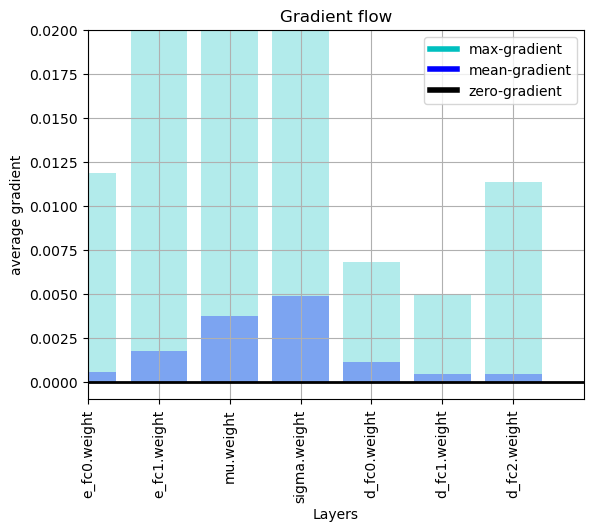

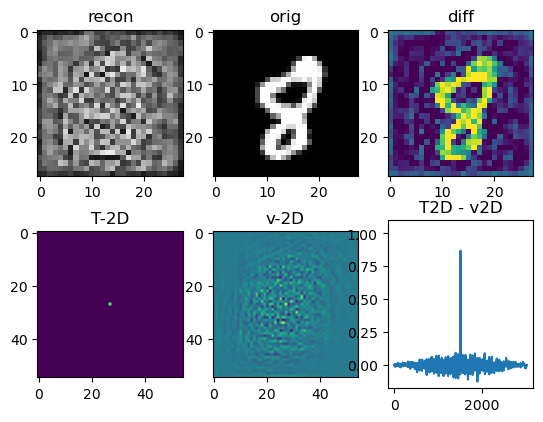

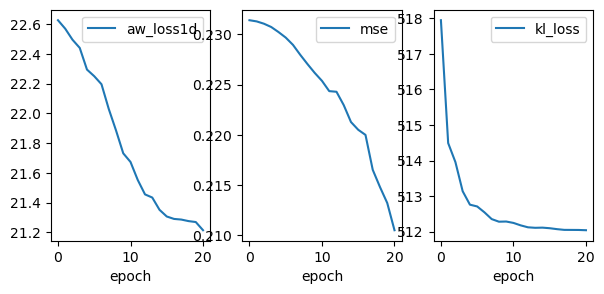

 40% (40 of 100) |#########              | Elapsed Time: 0:04:18 ETA:   0:06:27


 {'epoch': 40, 'train_mse': 0.15849021077156067, 'train_awi1d_loss': 21.061542510986328, 'train_kl_loss': 512.003173828125}
 argidx T, v:  1512 1512


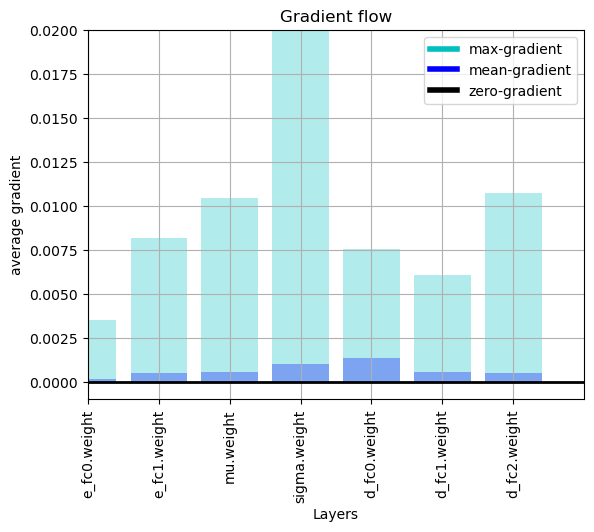

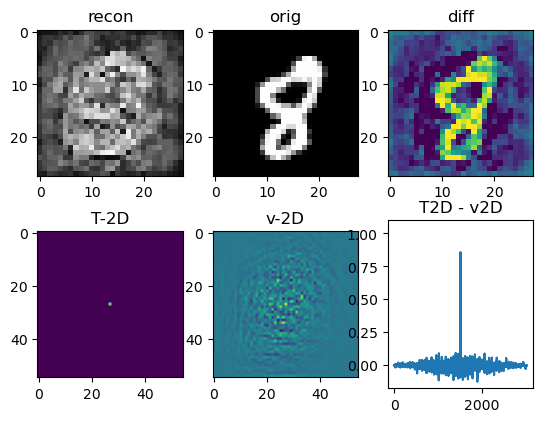

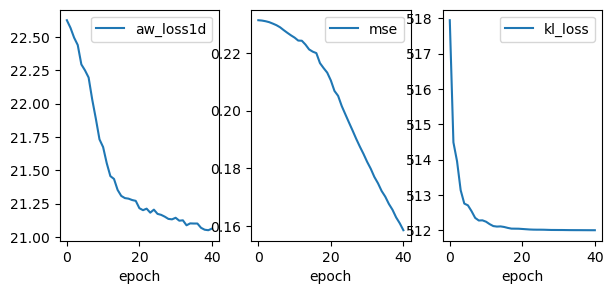

 60% (60 of 100) |#############          | Elapsed Time: 0:06:28 ETA:   0:04:16


 {'epoch': 60, 'train_mse': 0.13085561990737915, 'train_awi1d_loss': 20.900266647338867, 'train_kl_loss': 512.0013427734375}
 argidx T, v:  1512 1512


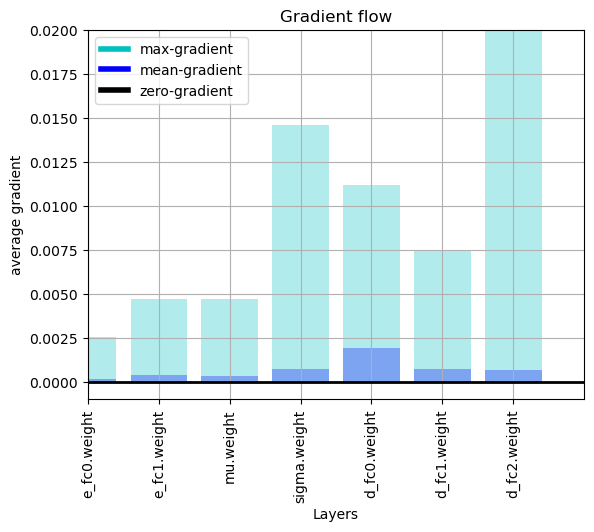

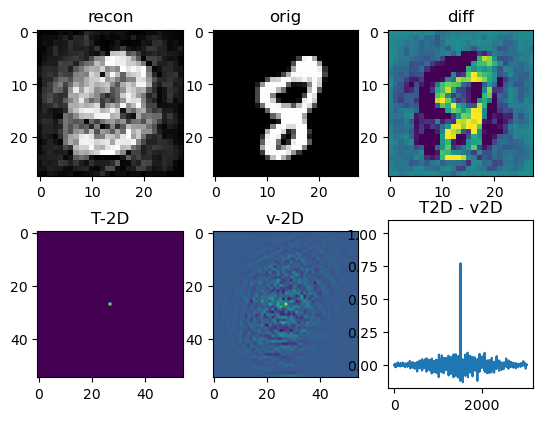

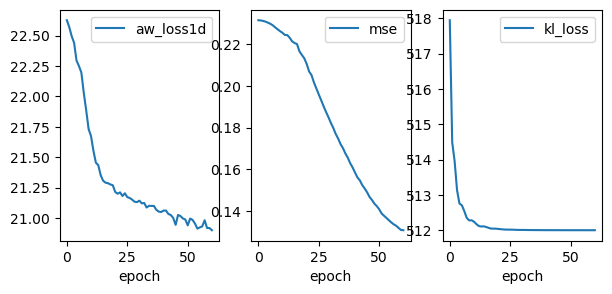

 80% (80 of 100) |##################     | Elapsed Time: 0:08:37 ETA:   0:02:08


 {'epoch': 80, 'train_mse': 0.12465931475162506, 'train_awi1d_loss': 20.792224884033203, 'train_kl_loss': 512.00146484375}
 argidx T, v:  1512 1512


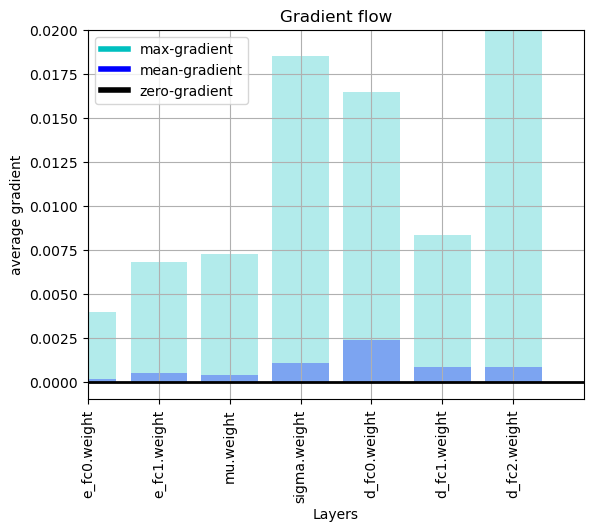

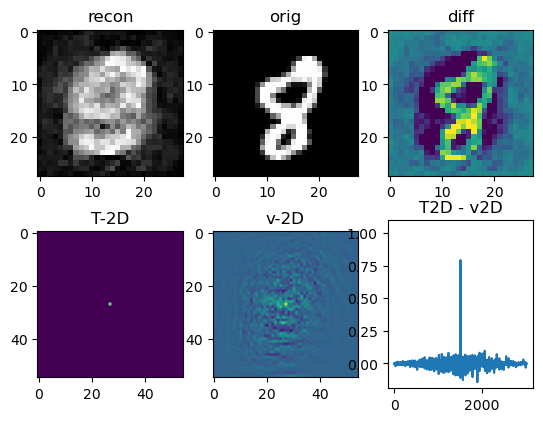

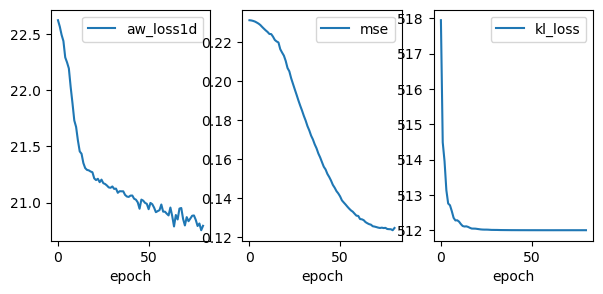

 99% (99 of 100) |###################### | Elapsed Time: 0:10:40 ETA:   0:00:06


 {'epoch': 99, 'train_mse': 0.12622568011283875, 'train_awi1d_loss': 20.761512756347656, 'train_kl_loss': 512.0017700195312}
 argidx T, v:  1512 1512


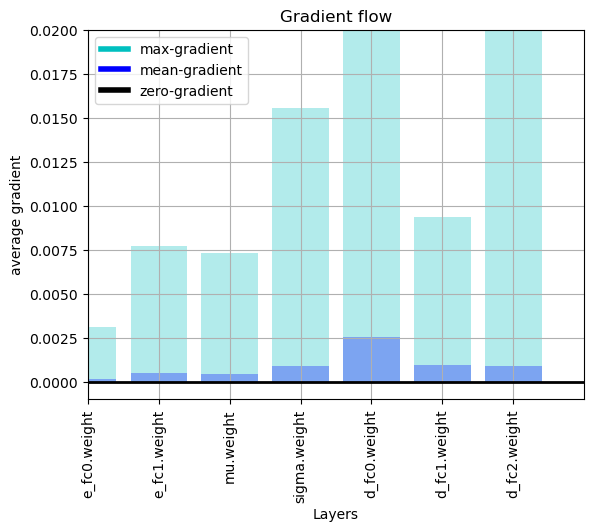

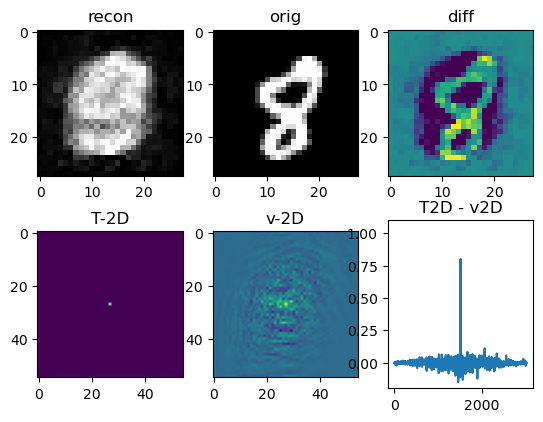

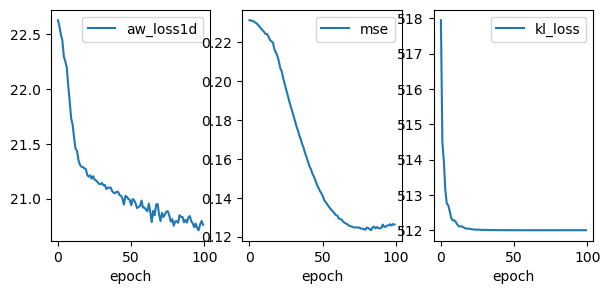

100% (100 of 100) |######################| Elapsed Time: 0:10:41 Time:  0:10:41


In [14]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.2774723768234253, 'train_awi1d_loss': 22.61062240600586, 'train_kl_loss': 0.0}
 argidx T, v:  1512 752


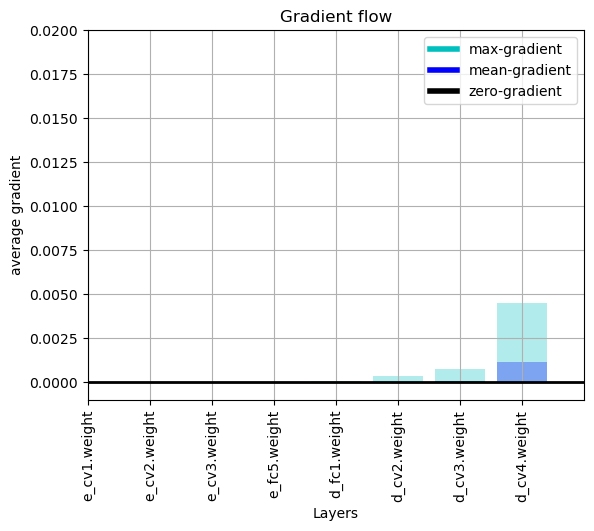

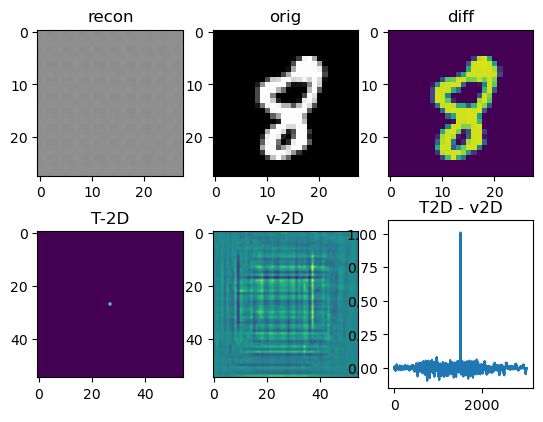

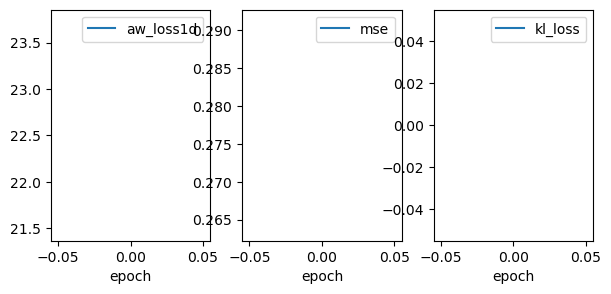

 20% (20 of 100) |####                   | Elapsed Time: 0:02:10 ETA:   0:08:39


 {'epoch': 20, 'train_mse': 0.2644946277141571, 'train_awi1d_loss': 21.27972412109375, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1896


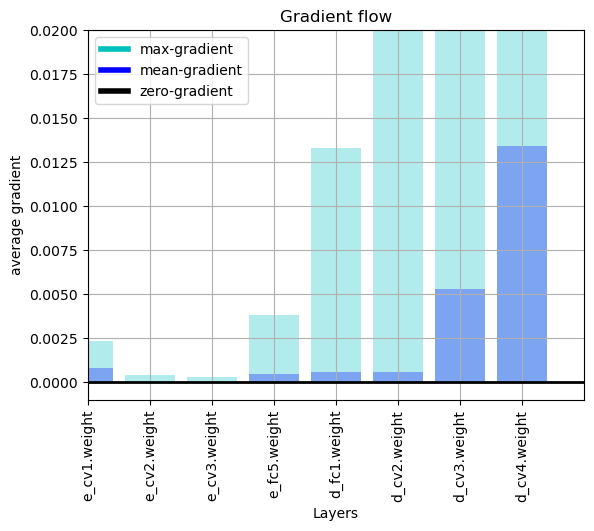

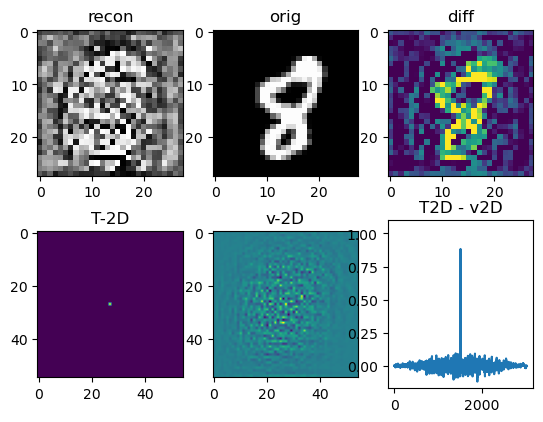

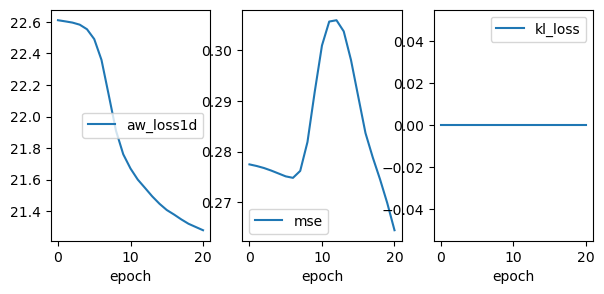

 40% (40 of 100) |#########              | Elapsed Time: 0:04:21 ETA:   0:06:28


 {'epoch': 40, 'train_mse': 0.17839065194129944, 'train_awi1d_loss': 20.74951934814453, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


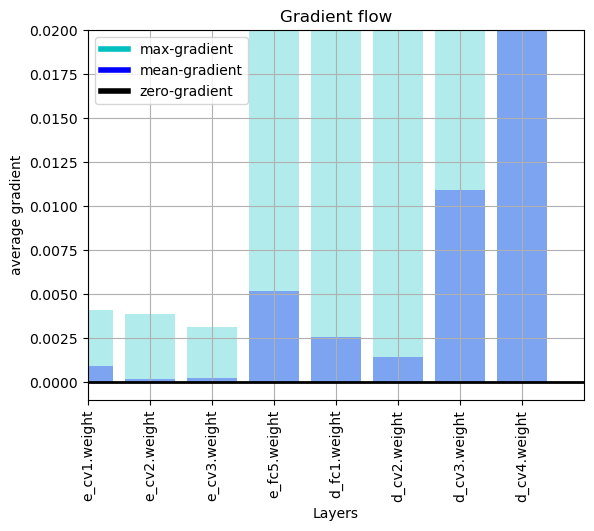

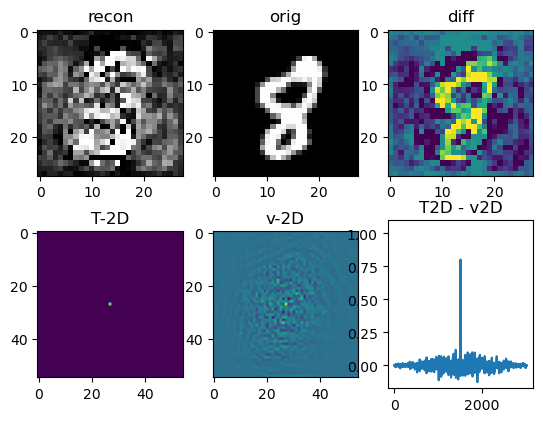

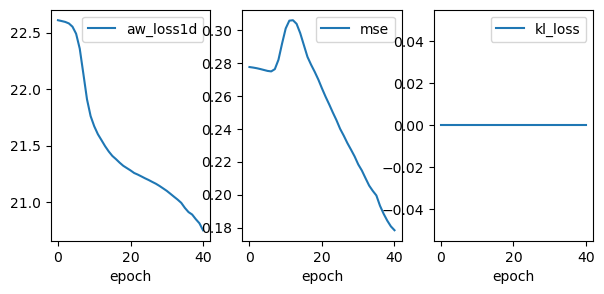

 60% (60 of 100) |#############          | Elapsed Time: 0:06:32 ETA:   0:04:19


 {'epoch': 60, 'train_mse': 0.13109172880649567, 'train_awi1d_loss': 19.655651092529297, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


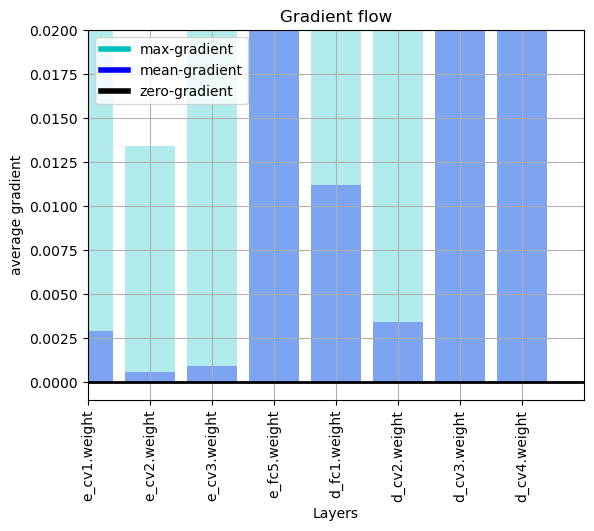

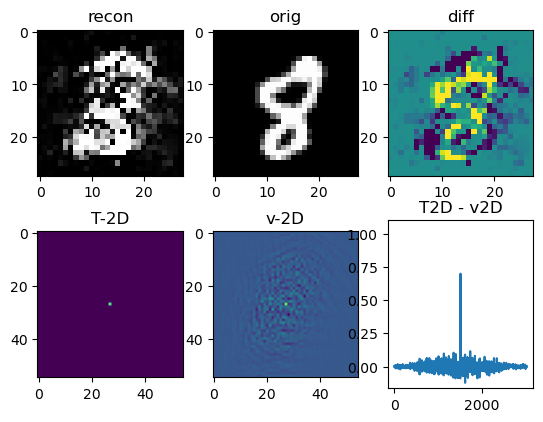

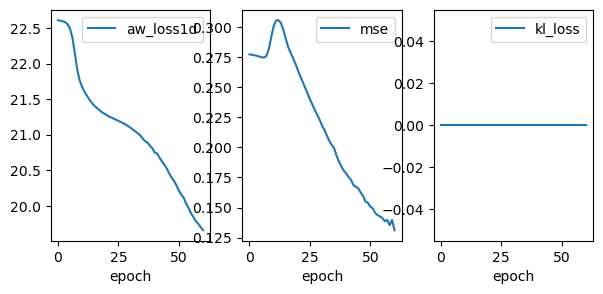

 80% (80 of 100) |##################     | Elapsed Time: 0:08:43 ETA:   0:02:09


 {'epoch': 80, 'train_mse': 0.12028834968805313, 'train_awi1d_loss': 18.570758819580078, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


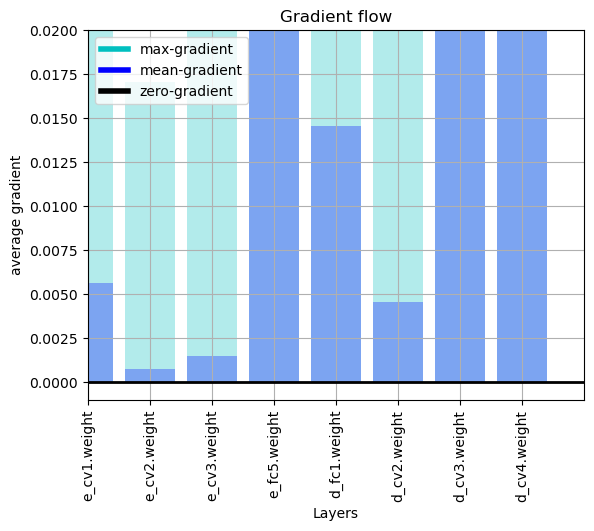

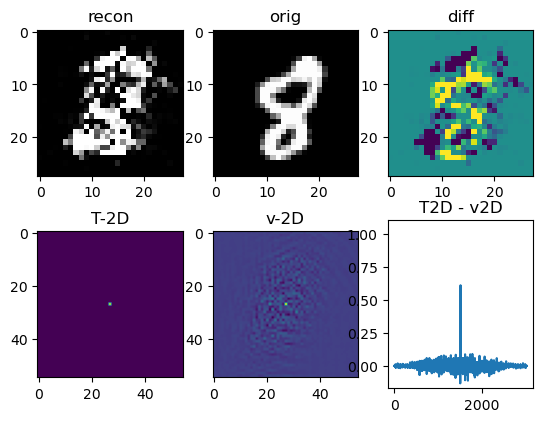

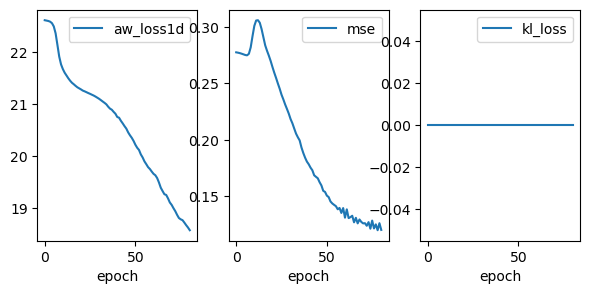

 99% (99 of 100) |###################### | Elapsed Time: 0:10:47 ETA:   0:00:06


 {'epoch': 99, 'train_mse': 0.11773401498794556, 'train_awi1d_loss': 17.825302124023438, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


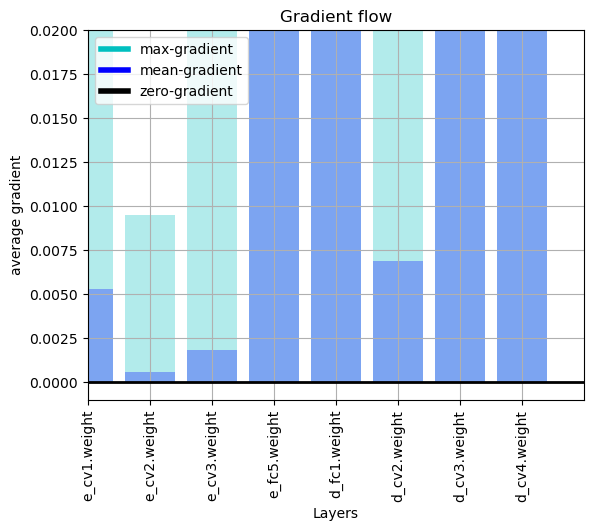

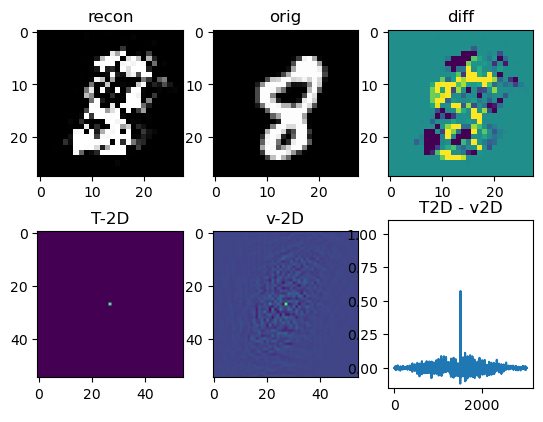

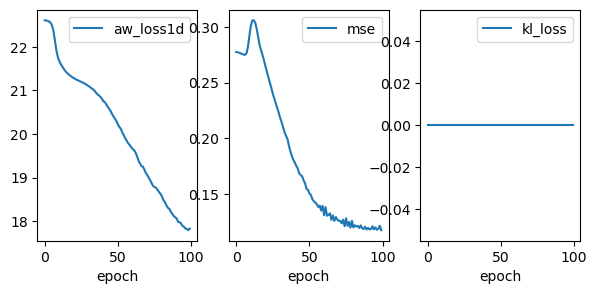

100% (100 of 100) |######################| Elapsed Time: 0:10:48 Time:  0:10:48


In [15]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.25124478340148926, 'train_awi1d_loss': 22.608932495117188, 'train_kl_loss': 519.6771240234375}
 argidx T, v:  1512 752


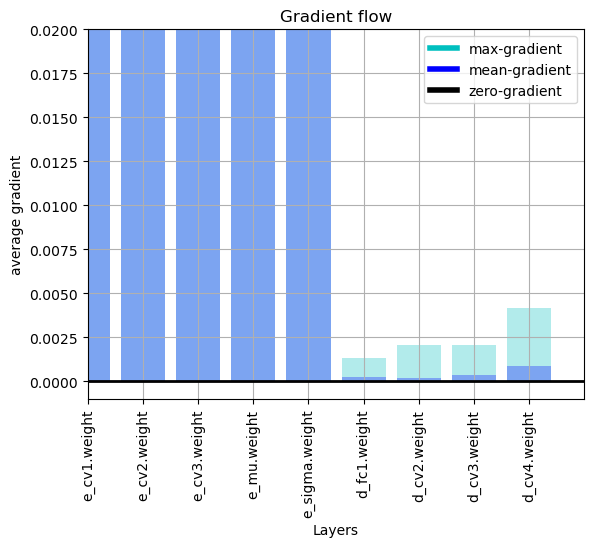

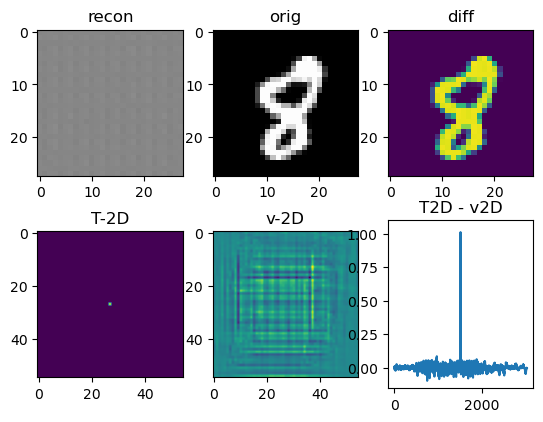

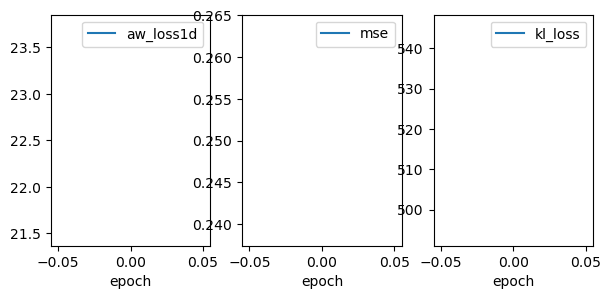

 20% (20 of 100) |####                   | Elapsed Time: 0:02:10 ETA:   0:08:35


 {'epoch': 20, 'train_mse': 0.237714022397995, 'train_awi1d_loss': 22.316314697265625, 'train_kl_loss': 512.0313720703125}
 argidx T, v:  1512 752


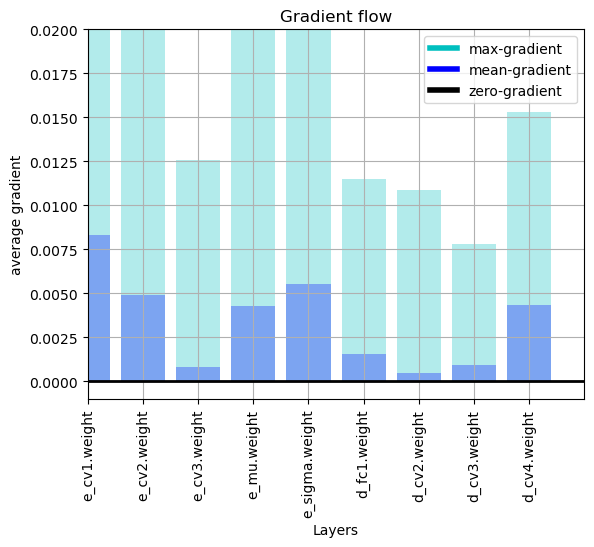

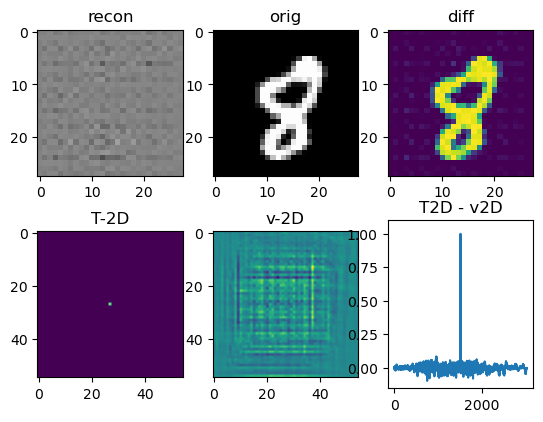

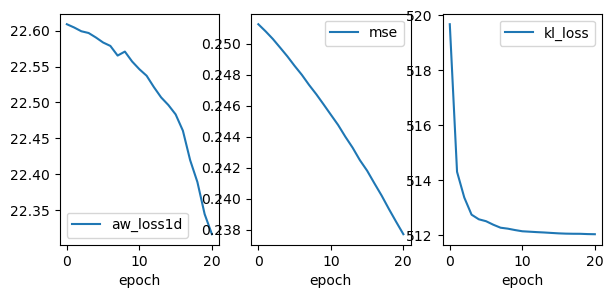

 40% (40 of 100) |#########              | Elapsed Time: 0:04:23 ETA:   0:06:38


 {'epoch': 40, 'train_mse': 0.23425257205963135, 'train_awi1d_loss': 21.552173614501953, 'train_kl_loss': 512.00830078125}
 argidx T, v:  1512 1896


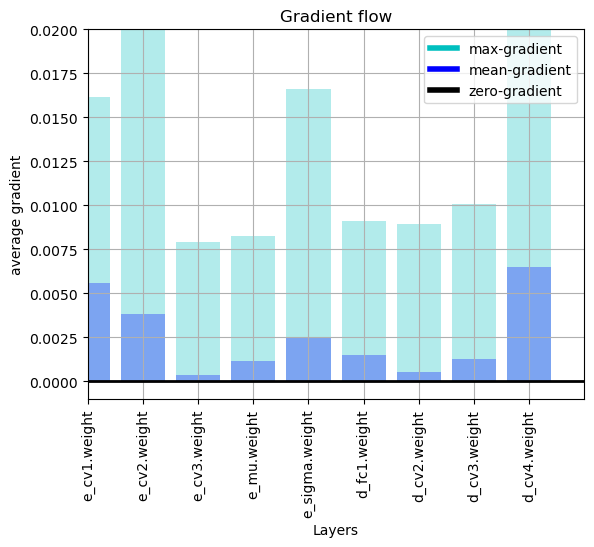

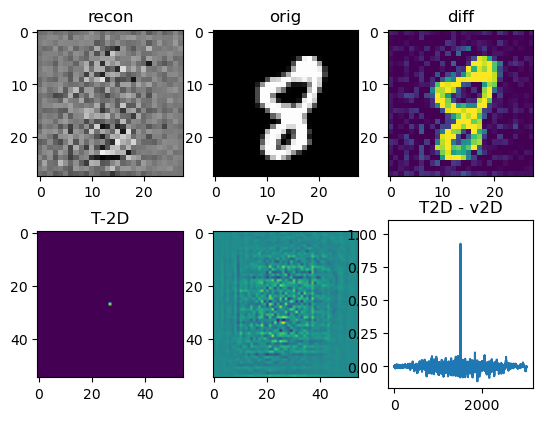

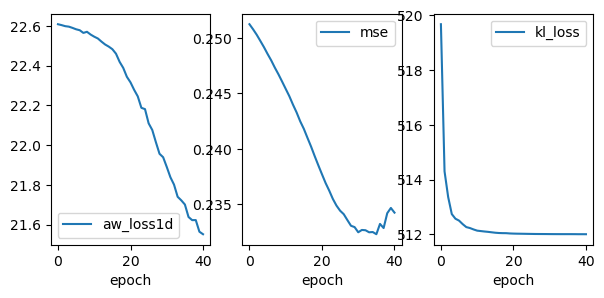

 60% (60 of 100) |#############          | Elapsed Time: 0:06:36 ETA:   0:04:23


 {'epoch': 60, 'train_mse': 0.23093152046203613, 'train_awi1d_loss': 21.339946746826172, 'train_kl_loss': 512.0042724609375}
 argidx T, v:  1512 1896


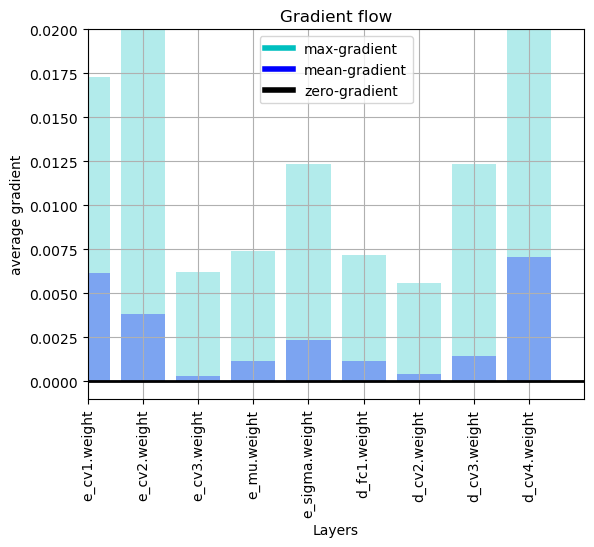

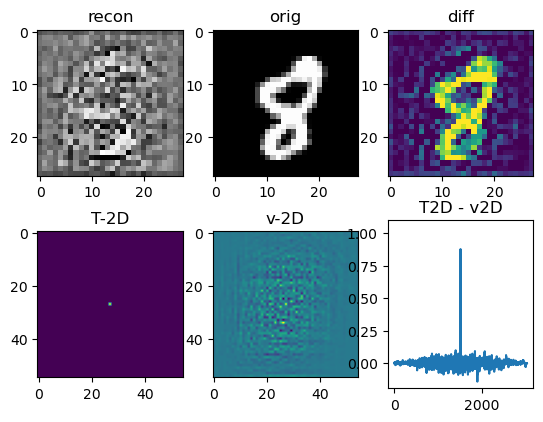

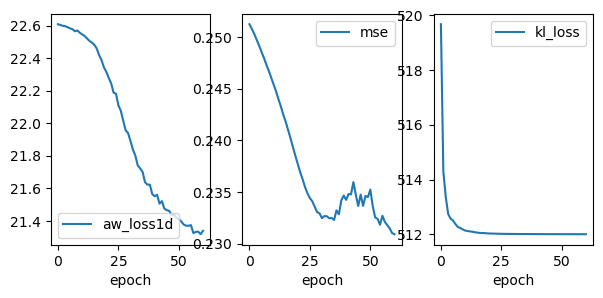

 80% (80 of 100) |##################     | Elapsed Time: 0:08:47 ETA:   0:02:09


 {'epoch': 80, 'train_mse': 0.21357792615890503, 'train_awi1d_loss': 21.224552154541016, 'train_kl_loss': 512.0023193359375}
 argidx T, v:  1512 1896


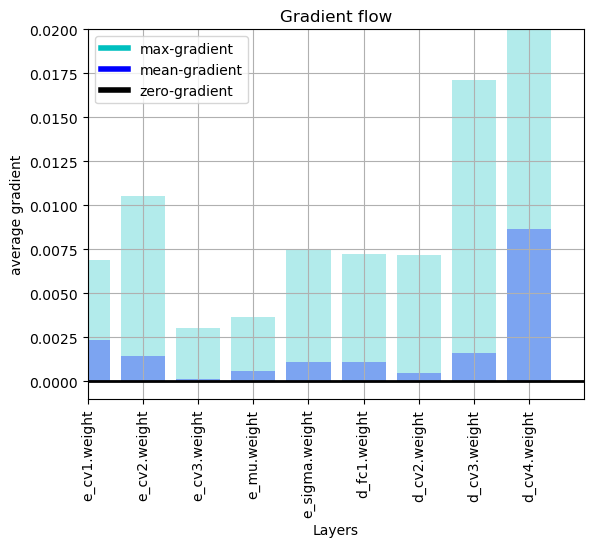

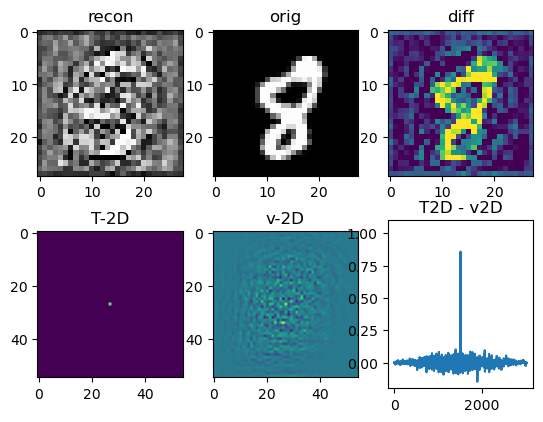

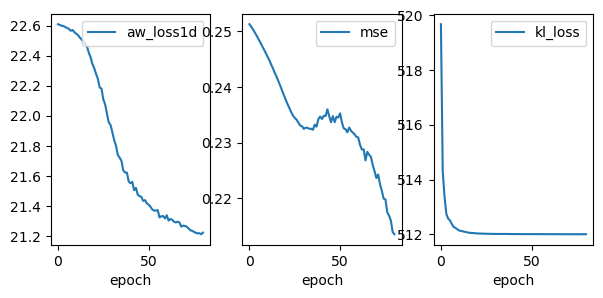

 99% (99 of 100) |###################### | Elapsed Time: 0:10:51 ETA:   0:00:06


 {'epoch': 99, 'train_mse': 0.1790725290775299, 'train_awi1d_loss': 21.116901397705078, 'train_kl_loss': 512.00146484375}
 argidx T, v:  1512 1512


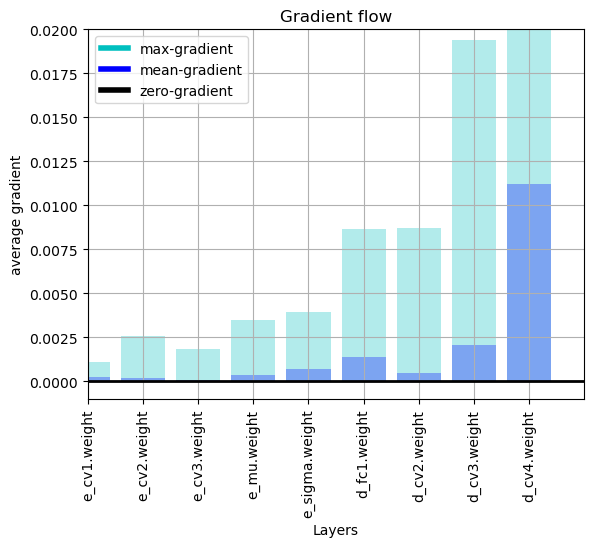

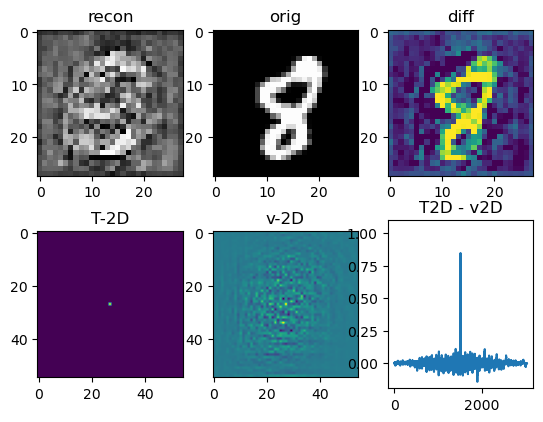

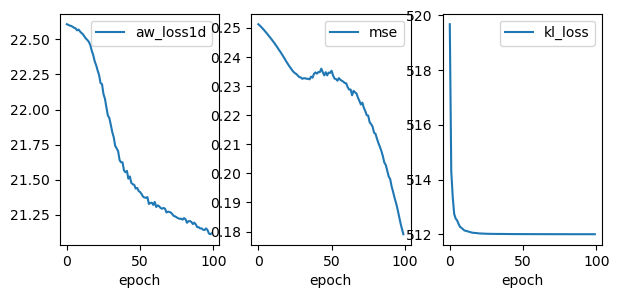

100% (100 of 100) |######################| Elapsed Time: 0:10:52 Time:  0:10:52


In [16]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)